### Data Analysis on Salary and Stats for NBA Players
We run statistical analyses to see how salary is correlated with both traditional and advanced stats like Points, Rebounds, PER, OBPM, etc. We then compute the players that most overperform their salaries in these statistical categories and the players that most underperform their salaries in these statistical categories. This enables us to identify the most overpaid and underpaid players in the NBA.

In [69]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
sns.set_style("darkgrid")

In [23]:
# import data from all the csv files
salary_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/2021-22 NBA Player Salaries - Sheet1.csv")
total_stats_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/Player Total Stats.csv")
advanced_stats_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/Player Advanced Stats.csv", encoding="ISO-8859-1")
stats_per_100_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/Player Stats Per 100 Possessions.csv")
stats_per_36_df = pd.read_csv("drive/MyDrive/MS&E 125 Project/Player Stats Per 36 Minutes.csv")

### Data Munging Section

In [24]:
# Split 'POSITION' from 'NAME' column in salary_df, shift accordingly
salary_df[['NAME', 'POSITION']] = salary_df['NAME'].str.split(', ', expand=True)
salary_df = salary_df.reindex(columns=['RK', 'NAME', 'POSITION', 'TEAM', 'SALARY'])

# Display salary dataframe
salary_df

,RK,NAME,POSITION,TEAM,SALARY
0,1,Stephen Curry,PG,Golden State Warriors,"$45,780,966"
1,2,James Harden,SG,Philadelphia 76ers,"$44,310,840"
2,3,John Wall,PG,Houston Rockets,"$44,310,840"
3,4,Russell Westbrook,PG,Los Angeles Lakers,"$44,211,146"
4,5,Kevin Durant,PF,Brooklyn Nets,"$42,018,900"
...,...,...,...,...,...
496,497,Juwan Morgan,F,Toronto Raptors,"$19,816"
497,498,Moses Brown,C,Cleveland Cavaliers,"$19,186"
498,499,Xavier Sneed,F,Utah Jazz,"$8,558"
499,500,Kessler Edwards,SF,Brooklyn Nets,"$5,318"


In [74]:
# sum together the stat totals for players that played on multiple teams
total_stats_df = total_stats_df.groupby('Player').sum().reset_index()

# average together the advanced stats totals for players that played on multiple teams
advanced_stats_df = advanced_stats_df.groupby('Player').mean().reset_index()

# average together the stats per 100 possessions totals for players that played on multiple teams
stats_per_100_df = stats_per_100_df.groupby('Player').mean().reset_index()

# average together the stats per 36 minutes totals for players that played on multiple teams
stats_per_36_df = stats_per_36_df.groupby('Player').mean().reset_index()

In [100]:
# join dataframes

# Merge the datasets on the "NAME" column in salaries and the "Player" column in the stats dfs
total_stats_salary_df = pd.merge(salary_df, total_stats_df, left_on='NAME', right_on='Player', how='outer')
advanced_stats_salary_df = pd.merge(salary_df, advanced_stats_df, left_on='NAME', right_on='Player', how='outer')
stats_per_100_salary_df = pd.merge(salary_df, stats_per_100_df, left_on='NAME', right_on='Player', how='outer')
stats_per_36_salary_df = pd.merge(salary_df, stats_per_36_df, left_on='NAME', right_on='Player', how='outer')

# drop the rows that don't have values for name or salary
total_stats_salary_df = total_stats_salary_df[total_stats_salary_df.NAME.notnull()]
total_stats_salary_df = total_stats_salary_df[total_stats_salary_df.SALARY.notnull()]
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.NAME.notnull()]
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.SALARY.notnull()]
stats_per_100_salary_df = stats_per_100_salary_df[stats_per_100_salary_df.NAME.notnull()]
stats_per_100_salary_df = stats_per_100_salary_df[stats_per_100_salary_df.SALARY.notnull()]
stats_per_36_salary_df = stats_per_36_salary_df[stats_per_36_salary_df.NAME.notnull()]
stats_per_36_salary_df = stats_per_36_salary_df[stats_per_36_salary_df.SALARY.notnull()]

# drop the rows that don't have values for certain advanced stats
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.VORP.notnull()]
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.WS.notnull()]
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.PER.notnull()]
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.OBPM.notnull()]
advanced_stats_salary_df = advanced_stats_salary_df[advanced_stats_salary_df.DBPM.notnull()]

# drop the rows that don't have values for traditional stats
total_stats_salary_df = total_stats_salary_df[total_stats_salary_df.PTS.notnull()]
stats_per_100_salary_df = stats_per_100_salary_df[stats_per_100_salary_df.PTS.notnull()]
stats_per_36_salary_df = stats_per_36_salary_df[stats_per_36_salary_df.PTS.notnull()]

# convert the salaries to numerical values
total_stats_salary_df['SALARY'] = total_stats_salary_df['SALARY'].replace('[\$,]', '', regex=True).astype(float)
advanced_stats_salary_df['SALARY'] = advanced_stats_salary_df['SALARY'].replace('[\$,]', '', regex=True).astype(float)
stats_per_100_salary_df['SALARY'] = stats_per_100_salary_df['SALARY'].replace('[\$,]', '', regex=True).astype(float)
stats_per_36_salary_df['SALARY'] = stats_per_36_salary_df['SALARY'].replace('[\$,]', '', regex=True).astype(float)

display(total_stats_salary_df, advanced_stats_salary_df, stats_per_100_salary_df, stats_per_36_salary_df)

,RK,NAME,POSITION,TEAM,SALARY,Player,Rk,Age,G,GS,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Stephen Curry,PG,Golden State Warriors,45780966.0,Stephen Curry,126.0,33.0,64.0,64.0,...,0.923,34.0,301.0,335.0,404.0,85.0,23.0,206.0,130.0,1630.0
1,2.0,James Harden,SG,Philadelphia 76ers,44310840.0,James Harden,654.0,96.0,130.0,130.0,...,2.638,110.0,890.0,1000.0,1334.0,164.0,72.0,568.0,306.0,2864.0
3,4.0,Russell Westbrook,PG,Los Angeles Lakers,44211146.0,Russell Westbrook,576.0,33.0,78.0,78.0,...,0.667,110.0,470.0,580.0,550.0,75.0,20.0,295.0,235.0,1441.0
4,5.0,Kevin Durant,PF,Brooklyn Nets,42018900.0,Kevin Durant,154.0,33.0,55.0,55.0,...,0.910,29.0,378.0,407.0,351.0,48.0,52.0,191.0,113.0,1643.0
5,6.0,LeBron James,SF,Los Angeles Lakers,41180544.0,LeBron James,274.0,37.0,56.0,56.0,...,0.756,63.0,396.0,459.0,349.0,73.0,59.0,196.0,121.0,1695.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.0,Juwan Morgan,F,Toronto Raptors,19816.0,Juwan Morgan,1173.0,72.0,4.0,0.0,...,0.000,4.0,4.0,8.0,2.0,0.0,0.0,0.0,6.0,10.0
497,498.0,Moses Brown,C,Cleveland Cavaliers,19186.0,Moses Brown,231.0,66.0,80.0,12.0,...,1.777,78.0,192.0,270.0,2.0,14.0,32.0,40.0,106.0,342.0
498,499.0,Xavier Sneed,F,Utah Jazz,8558.0,Xavier Sneed,1539.0,72.0,18.0,0.0,...,0.000,4.0,8.0,12.0,2.0,0.0,0.0,0.0,4.0,10.0
499,500.0,Kessler Edwards,SF,Brooklyn Nets,5318.0,Kessler Edwards,158.0,21.0,48.0,23.0,...,0.842,44.0,128.0,172.0,31.0,29.0,24.0,42.0,85.0,284.0


,RK,NAME,POSITION,TEAM,SALARY,Player,Rk,Age,G,MP,...,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP
0,1.0,Stephen Curry,PG,Golden State Warriors,45780966.0,Stephen Curry,126.0,33.0,64.000000,2211.000000,...,NaN,4.600000,3.400000,8.000000,0.173000,NaN,5.400000,0.400000,5.800000,4.400000
1,2.0,James Harden,SG,Philadelphia 76ers,44310840.0,James Harden,218.0,32.0,43.333333,1612.666667,...,NaN,3.266667,1.800000,5.100000,0.159667,NaN,3.733333,0.266667,3.966667,2.466667
3,4.0,Russell Westbrook,PG,Los Angeles Lakers,44211146.0,Russell Westbrook,576.0,33.0,78.000000,2678.000000,...,NaN,-0.600000,2.300000,1.700000,0.030000,NaN,-0.700000,-0.900000,-1.600000,0.200000
4,5.0,Kevin Durant,PF,Brooklyn Nets,42018900.0,Kevin Durant,154.0,33.0,55.000000,2047.000000,...,NaN,6.400000,2.000000,8.400000,0.198000,NaN,6.400000,0.700000,7.200000,4.800000
5,6.0,LeBron James,SF,Los Angeles Lakers,41180544.0,LeBron James,274.0,37.0,56.000000,2084.000000,...,NaN,5.200000,2.300000,7.500000,0.172000,NaN,6.900000,0.800000,7.700000,5.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.0,Juwan Morgan,F,Toronto Raptors,19816.0,Juwan Morgan,391.0,24.0,1.333333,20.666667,...,NaN,0.066667,0.000000,0.066667,0.095667,NaN,-3.500000,-3.366667,-6.800000,0.000000
497,498.0,Moses Brown,C,Cleveland Cavaliers,19186.0,Moses Brown,77.0,22.0,26.666667,230.000000,...,NaN,0.333333,0.433333,0.800000,0.159333,NaN,-2.433333,-0.933333,-3.333333,-0.066667
498,499.0,Xavier Sneed,F,Utah Jazz,8558.0,Xavier Sneed,513.0,24.0,6.000000,26.000000,...,NaN,-0.033333,0.000000,0.000000,-0.077333,NaN,-8.766667,-4.166667,-12.900000,-0.033333
499,500.0,Kessler Edwards,SF,Brooklyn Nets,5318.0,Kessler Edwards,158.0,21.0,48.000000,987.000000,...,NaN,-0.200000,0.900000,0.600000,0.031000,NaN,-3.100000,-0.800000,-3.800000,-0.500000


,RK,NAME,POSITION,TEAM,SALARY,Player,Rk,Age,G,GS,...,TRB,AST,STL,BLK,TOV,PF,PTS,Unnamed: 29,ORtg,DRtg
0,1.0,Stephen Curry,PG,Golden State Warriors,45780966.0,Stephen Curry,126.0,33.0,64.000000,64.000000,...,7.400000,8.900000,1.900000,0.500000,4.500000,2.900000,35.900000,NaN,115.000000,108.000000
1,2.0,James Harden,SG,Philadelphia 76ers,44310840.0,James Harden,218.0,32.0,43.333333,43.333333,...,10.000000,13.566667,1.666667,0.633333,5.500000,3.066667,28.766667,NaN,116.333333,111.000000
3,4.0,Russell Westbrook,PG,Los Angeles Lakers,44211146.0,Russell Westbrook,576.0,33.0,78.000000,78.000000,...,10.400000,9.800000,1.300000,0.400000,5.300000,4.200000,25.800000,NaN,102.000000,114.000000
4,5.0,Kevin Durant,PF,Brooklyn Nets,42018900.0,Kevin Durant,154.0,33.0,55.000000,55.000000,...,9.600000,8.300000,1.100000,1.200000,4.500000,2.700000,38.900000,NaN,121.000000,112.000000
5,6.0,LeBron James,SF,Los Angeles Lakers,41180544.0,LeBron James,274.0,37.0,56.000000,56.000000,...,10.600000,8.000000,1.700000,1.400000,4.500000,2.800000,39.000000,NaN,117.000000,111.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.0,Juwan Morgan,F,Toronto Raptors,19816.0,Juwan Morgan,391.0,24.0,1.333333,0.000000,...,4.600000,1.166667,0.000000,0.000000,0.000000,3.466667,5.800000,NaN,184.000000,117.666667
497,498.0,Moses Brown,C,Cleveland Cavaliers,19186.0,Moses Brown,77.0,22.0,26.666667,4.000000,...,19.600000,0.133333,1.000000,2.333333,2.933333,7.700000,24.800000,NaN,115.666667,105.000000
498,499.0,Xavier Sneed,F,Utah Jazz,8558.0,Xavier Sneed,513.0,24.0,6.000000,0.000000,...,8.666667,0.966667,0.000000,0.000000,0.000000,4.833333,4.766667,NaN,66.000000,116.333333
499,500.0,Kessler Edwards,SF,Brooklyn Nets,5318.0,Kessler Edwards,158.0,21.0,48.000000,23.000000,...,8.400000,1.500000,1.400000,1.200000,2.100000,4.200000,13.900000,NaN,100.000000,113.000000


,RK,NAME,POSITION,TEAM,SALARY,Player,Rk,Age,G,GS,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Stephen Curry,PG,Golden State Warriors,45780966.0,Stephen Curry,126.0,33.0,64.000000,64.000000,...,0.923000,0.600000,4.900000,5.500000,6.600000,1.4,0.400000,3.400000,2.100000,26.500000
1,2.0,James Harden,SG,Philadelphia 76ers,44310840.0,James Harden,218.0,32.0,43.333333,43.333333,...,0.879333,0.766667,6.533333,7.333333,9.933333,1.2,0.466667,4.066667,2.266667,21.100000
3,4.0,Russell Westbrook,PG,Los Angeles Lakers,44211146.0,Russell Westbrook,576.0,33.0,78.000000,78.000000,...,0.667000,1.500000,6.300000,7.800000,7.400000,1.0,0.300000,4.000000,3.200000,19.400000
4,5.0,Kevin Durant,PF,Brooklyn Nets,42018900.0,Kevin Durant,154.0,33.0,55.000000,55.000000,...,0.910000,0.500000,6.600000,7.200000,6.200000,0.8,0.900000,3.400000,2.000000,28.900000
5,6.0,LeBron James,SF,Los Angeles Lakers,41180544.0,LeBron James,274.0,37.0,56.000000,56.000000,...,0.756000,1.100000,6.800000,7.900000,6.000000,1.3,1.000000,3.400000,2.100000,29.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.0,Juwan Morgan,F,Toronto Raptors,19816.0,Juwan Morgan,391.0,24.0,1.333333,0.000000,...,NaN,1.666667,1.666667,3.300000,0.833333,0.0,0.000000,0.000000,2.500000,4.166667
497,498.0,Moses Brown,C,Cleveland Cavaliers,19186.0,Moses Brown,77.0,22.0,26.666667,4.000000,...,0.592333,4.066667,10.000000,14.066667,0.100000,0.7,1.666667,2.100000,5.533333,17.833333
498,499.0,Xavier Sneed,F,Utah Jazz,8558.0,Xavier Sneed,513.0,24.0,6.000000,0.000000,...,NaN,2.500000,3.900000,6.366667,0.700000,0.0,0.000000,0.000000,3.600000,3.466667
499,500.0,Kessler Edwards,SF,Brooklyn Nets,5318.0,Kessler Edwards,158.0,21.0,48.000000,23.000000,...,0.842000,1.600000,4.700000,6.300000,1.100000,1.1,0.900000,1.500000,3.100000,10.400000


### Total Stats Section

In [59]:
# compute correlations to see what total stats are most correlated with salary
total_corrs = total_stats_salary_df.corr()['SALARY']
total_corrs

<ipython-input-59-dd0894e5e53f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  total_corrs = total_stats_salary_df.corr()['SALARY']


RK       -0.815748
SALARY    1.000000
Rk       -0.086207
Age      -0.001509
G         0.162640
GS        0.521900
MP        0.448704
FG        0.580746
FGA       0.568342
FG%      -0.043698
3P        0.391494
3PA       0.400589
3P%      -0.002225
2P        0.560679
2PA       0.573534
2P%      -0.054924
eFG%     -0.050819
FT        0.609488
FTA       0.602139
FT%       0.031849
ORB       0.183440
DRB       0.470650
TRB       0.409317
AST       0.514099
STL       0.386287
BLK       0.260800
TOV       0.558531
PF        0.312847
PTS       0.596082
Name: SALARY, dtype: float64

<Axes: xlabel='FG', ylabel='SALARY'>

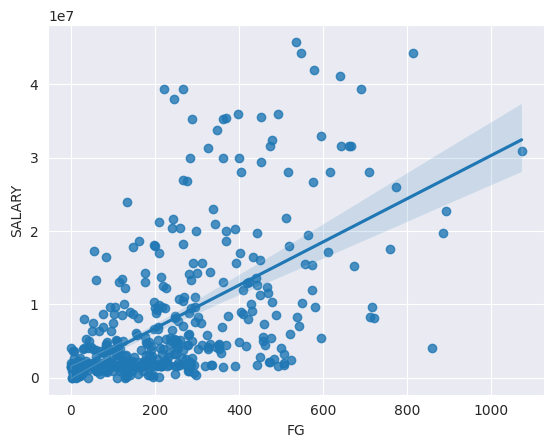

In [51]:
# run linear regressions and plot the outputs for total FG (Field Goals)
sns.regplot(x='FG', y='SALARY', data=total_stats_salary_df)

<Axes: xlabel='PTS', ylabel='SALARY'>

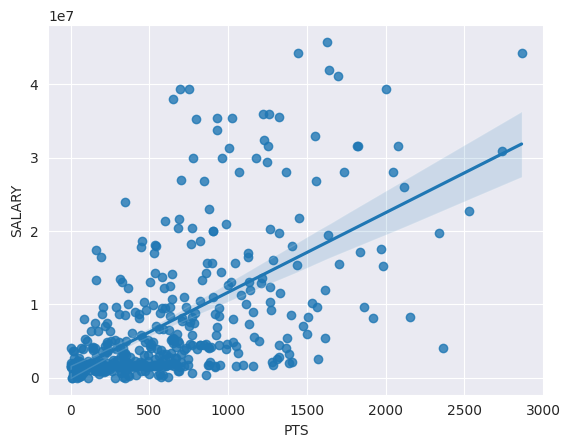

In [65]:
# run linear regressions and plot the outputs for total PTS (Points)
sns.regplot(x='PTS', y='SALARY', data=total_stats_salary_df)

<Axes: xlabel='AST', ylabel='SALARY'>

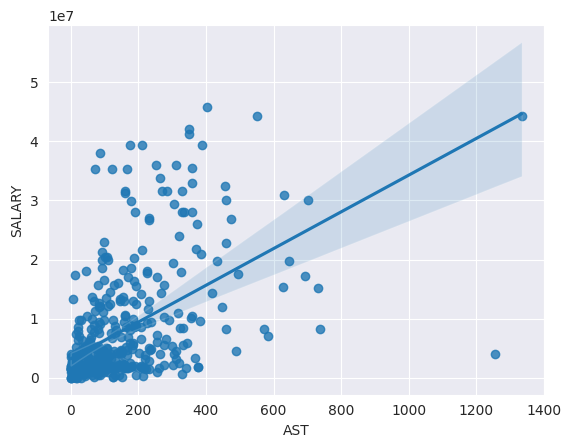

In [66]:
# run linear regressions and plot the outputs for total AST (Assists)
sns.regplot(x='AST', y='SALARY', data=total_stats_salary_df)

<Axes: xlabel='STL', ylabel='SALARY'>

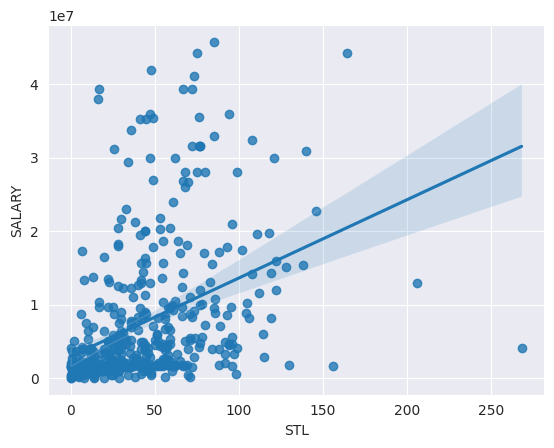

In [67]:
# run linear regressions and plot the outputs for total STL (Steals)
sns.regplot(x='STL', y='SALARY', data=total_stats_salary_df)

<Axes: xlabel='BLK', ylabel='SALARY'>

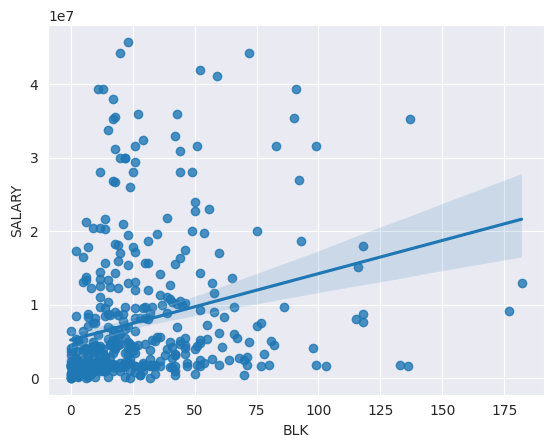

In [68]:
# run linear regressions and plot the outputs for total BLK (Blocks)
sns.regplot(x='BLK', y='SALARY', data=total_stats_salary_df)

### Advanced Stats Section

In [62]:
# compute correlations to see what advanced stats are most correlated with salary
advanced_corrs = advanced_stats_salary_df.corr()['SALARY']
advanced_corrs

<ipython-input-62-a8be576a5073>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  advanced_corrs = advanced_stats_salary_df.corr()['SALARY']


RK            -0.815748
SALARY         1.000000
Rk            -0.073823
Age            0.319315
G              0.228449
MP             0.486178
PER            0.475992
TS%            0.139252
3PAr          -0.077248
FTr            0.142254
ORB%          -0.150647
DRB%           0.130881
TRB%           0.022823
AST%           0.468155
STL%           0.027056
BLK%          -0.041289
TOV%           0.037192
USG%           0.549244
Unnamed: 19         NaN
OWS            0.489647
DWS            0.481272
WS             0.530838
WS/48          0.294214
Unnamed: 24         NaN
OBPM           0.569901
DBPM           0.104075
BPM            0.493528
VORP           0.639633
Name: SALARY, dtype: float64

<Axes: xlabel='VORP', ylabel='SALARY'>

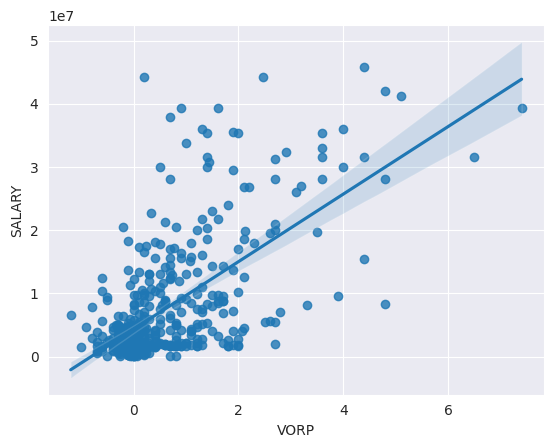

In [54]:
# run a linear regression and plot the output for VORP (Value over Replacement Player) and salary
sns.regplot(x='VORP', y='SALARY', data=advanced_stats_salary_df)

<Axes: xlabel='PER', ylabel='SALARY'>

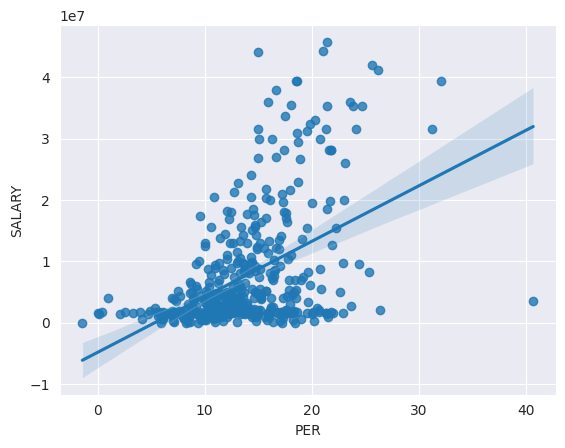

In [55]:
# run a linear regression and plot the output for PER (Player Efficiency Rating) and salary
sns.regplot(x='PER', y='SALARY', data=advanced_stats_salary_df)

<Axes: xlabel='WS', ylabel='SALARY'>

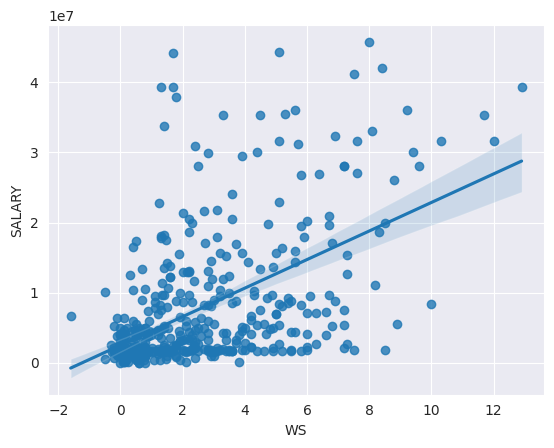

In [56]:
# run a linear regression and plot the output for WS (Win Shares) and salary
sns.regplot(x='WS', y='SALARY', data=advanced_stats_salary_df)

<Axes: xlabel='OBPM', ylabel='SALARY'>

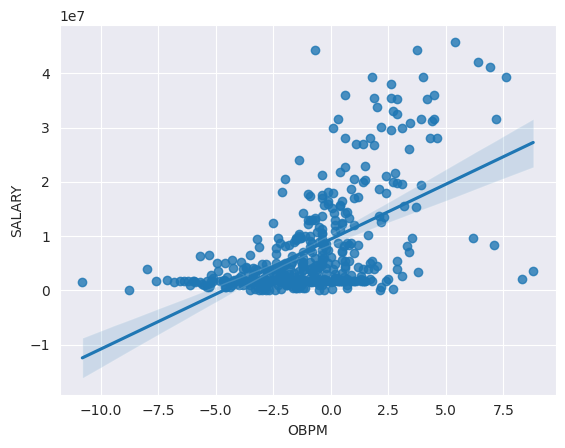

In [57]:
# run a linear regression and plot the output for OBPM (Offensive Box Plus Minus) and salary
sns.regplot(x='OBPM', y='SALARY', data=advanced_stats_salary_df)

<Axes: xlabel='DBPM', ylabel='SALARY'>

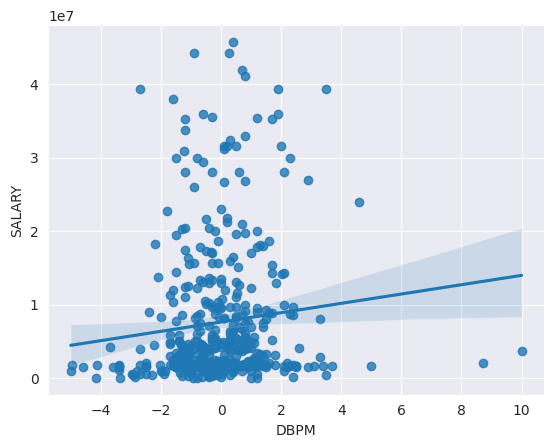

In [58]:
# run a linear regression and plot the output for DBPM (Defensive Box Plus Minus) and salary
sns.regplot(x='DBPM', y='SALARY', data=advanced_stats_salary_df)

### Stats Per 100 Possessions Section

In [60]:
# compute correlations to see what per 100 stats are most correlated with salary
per_100_corrs = stats_per_100_salary_df.corr()['SALARY']
per_100_corrs

<ipython-input-60-041865245f19>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  per_100_corrs = stats_per_100_salary_df.corr()['SALARY']


RK            -0.815748
SALARY         1.000000
Rk            -0.073823
Age            0.319315
G              0.228449
GS             0.530162
MP             0.486178
FG             0.510594
FGA            0.506335
FG%            0.066208
3P             0.205753
3PA            0.169308
3P%            0.033885
2P             0.363250
2PA            0.408458
2P%            0.003745
FT             0.503287
FTA            0.430372
FT%            0.214073
ORB           -0.153173
DRB            0.133964
TRB            0.022859
AST            0.414282
STL            0.027089
BLK           -0.040307
TOV            0.360860
PF            -0.255415
PTS            0.569101
Unnamed: 29         NaN
ORtg           0.112286
DRtg          -0.080684
Name: SALARY, dtype: float64

<Axes: xlabel='PTS', ylabel='SALARY'>

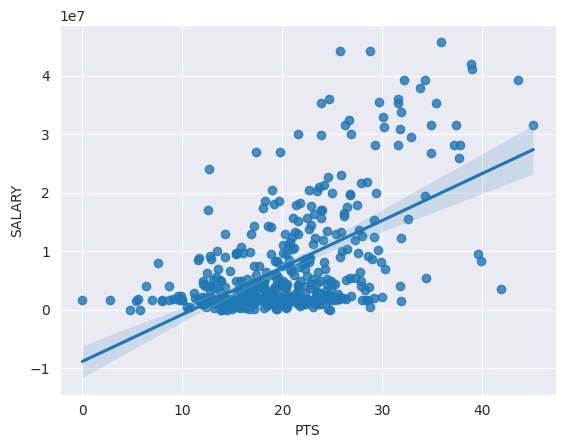

In [78]:
# run linear regressions and plot the outputs for PTS (Points) per 100 possessions
sns.regplot(x='PTS', y='SALARY', data=stats_per_100_salary_df)

<Axes: xlabel='AST', ylabel='SALARY'>

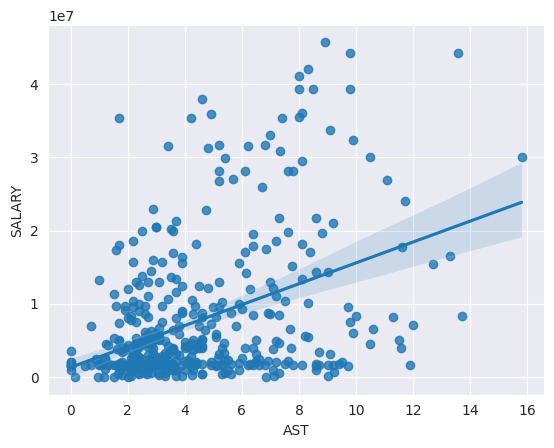

In [79]:
# run linear regressions and plot the outputs for AST (Assists) per 100 possessions
sns.regplot(x='AST', y='SALARY', data=stats_per_100_salary_df)

<Axes: xlabel='BLK', ylabel='SALARY'>

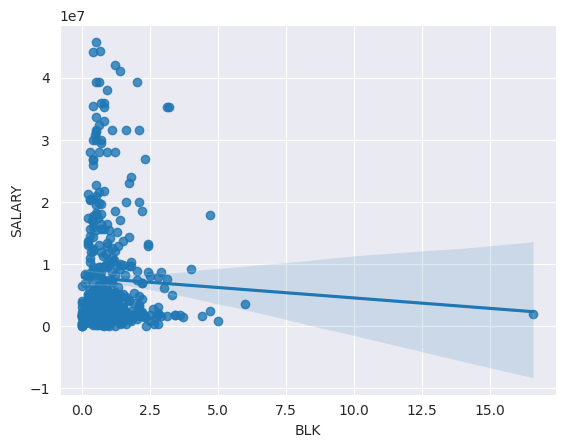

In [82]:
# run linear regressions and plot the outputs for BLK (Blocks) per 100 possessions
sns.regplot(x='BLK', y='SALARY', data=stats_per_100_salary_df)

### Stats Per 36 Minutes Section

In [61]:
# compute correlations to see what per 36 stats are most correlated with salary
per_36_corrs = stats_per_36_salary_df.corr()['SALARY']
per_36_corrs

<ipython-input-61-2541b373c511>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  per_36_corrs = stats_per_36_salary_df.corr()['SALARY']


RK       -0.815748
SALARY    1.000000
Rk       -0.073823
Age       0.319315
G         0.228449
GS        0.530162
MP        0.486178
FG        0.507712
FGA       0.504856
FG%       0.066208
3P        0.206833
3PA       0.169323
3P%       0.033885
2P        0.360880
2PA       0.407621
2P%       0.003745
FT        0.501495
FTA       0.431345
FT%       0.214073
ORB      -0.152252
DRB       0.132748
TRB       0.021723
AST       0.413530
STL       0.033023
BLK      -0.039099
TOV       0.363935
PF       -0.255124
PTS       0.565973
Name: SALARY, dtype: float64

<Axes: xlabel='PTS', ylabel='SALARY'>

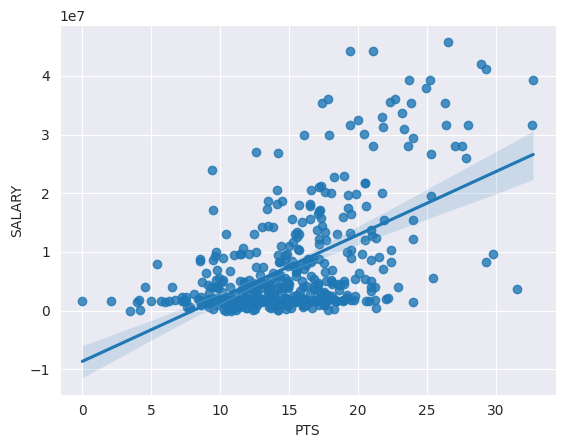

In [81]:
# run linear regressions and plot the outputs for PTS (Points) per 36 minutes
sns.regplot(x='PTS', y='SALARY', data=stats_per_36_salary_df)

<Axes: xlabel='BLK', ylabel='SALARY'>

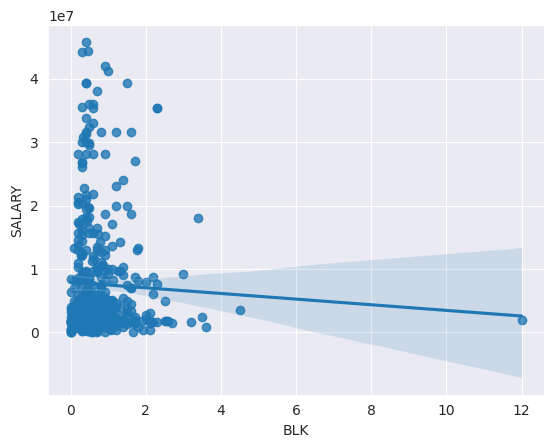

In [80]:
# run linear regressions and plot the outputs for BLK (Blocks) per 36 minutes
sns.regplot(x='BLK', y='SALARY', data=stats_per_36_salary_df)

### Identifying the most overpaid and underpaid players using advanced stats

Value Over Replacement Player

In [112]:
# Fit a linear regression model
model = LinearRegression().fit(advanced_stats_salary_df[['VORP']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(advanced_stats_salary_df[['VORP']])

# Calculate the residuals
residuals = advanced_stats_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in VORP: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in VORP: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in VORP: Russell Westbrook
Most underpaid player in VORP: Trae Young


Player Efficiency Rating

In [113]:
# Fit a linear regression model
model = LinearRegression().fit(advanced_stats_salary_df[['PER']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(advanced_stats_salary_df[['PER']])

# Calculate the residuals
residuals = advanced_stats_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in PER: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in PER: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in PER: Russell Westbrook
Most underpaid player in PER: Sekou Doumbouya


Win Shares

In [95]:
# Fit a linear regression model
model = LinearRegression().fit(advanced_stats_salary_df[['WS']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(advanced_stats_salary_df[['WS']])

# Calculate the residuals
residuals = advanced_stats_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in WS: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in WS: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in WS: Russell Westbrook
Most underpaid player in WS: Mitchell Robinson


Offensive Box Plus Minus

In [96]:
# Fit a linear regression model
model = LinearRegression().fit(advanced_stats_salary_df[['OBPM']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(advanced_stats_salary_df[['OBPM']])

# Calculate the residuals
residuals = advanced_stats_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in OBPM: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in OBPM: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in OBPM: Russell Westbrook
Most underpaid player in OBPM: Jaden Springer


Defensive Box Plus Minus

In [97]:
# Fit a linear regression model
model = LinearRegression().fit(advanced_stats_salary_df[['DBPM']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(advanced_stats_salary_df[['DBPM']])

# Calculate the residuals
residuals = advanced_stats_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in DBPM: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in DBPM: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in DBPM: Stephen Curry
Most underpaid player in DBPM: Jaden Springer


In [ ]:
# Fit a linear regression model
model = LinearRegression().fit(advanced_stats_salary_df[['DBPM']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(advanced_stats_salary_df[['DBPM']])

# Calculate the residuals
residuals = advanced_stats_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in DBPM: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in DBPM: {}".format(advanced_stats_salary_df['NAME'].iloc[idx_max_below]))

### Identifying the most overpaid and underpaid players using traditional stats

In [114]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['PTS']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['PTS']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in PTS per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in PTS per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in PTS per 100 possessions: Russell Westbrook
Most underpaid player in PTS per 100 possessions: Sekou Doumbouya


In [115]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['AST']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['AST']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in AST per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in AST per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in AST per 100 possessions: Stephen Curry
Most underpaid player in AST per 100 possessions: Rajon Rondo


In [116]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['BLK']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['BLK']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in BLK per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in BLK per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in BLK per 100 possessions: Stephen Curry
Most underpaid player in BLK per 100 possessions: Xavier Sneed


In [117]:
# Fit a linear regression model
model = LinearRegression().fit(stats_per_100_salary_df[['STL']], advanced_stats_salary_df['SALARY'])

# Calculate the predicted values
y_pred = model.predict(stats_per_100_salary_df[['STL']])

# Calculate the residuals
residuals = stats_per_100_salary_df['SALARY'] - y_pred

# Find the index of the data points that are most above and below the regression line
idx_max_above = np.argmax(residuals)
idx_max_below = np.argmin(residuals)

print("Most overpaid player in STL per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_above]))
print("Most underpaid player in STL per 100 possessions: {}".format(stats_per_100_salary_df['NAME'].iloc[idx_max_below]))

Most overpaid player in STL per 100 possessions: Stephen Curry
Most underpaid player in STL per 100 possessions: Jose Alvarado
